In [1]:
import numpy as np
import pandas as pd
import warnings
from causalnex.structure import StructureModel
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from networkx import DiGraph
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from networkx import DiGraph

warnings.filterwarnings("ignore")  # silence warnings

In [2]:
# create DIGraphs from adjacency matrices
def create_dag(adjacency_matrix, threshold=0.8):
    dag = DiGraph()
    dag.add_nodes_from(range(1, adjacency_matrix.shape[0]+1))
    for i in range(adjacency_matrix.shape[0]):
        for j in range(adjacency_matrix.shape[1]):
            if adjacency_matrix[i, j]>= threshold:
                dag.add_edge(i+1, j+1)
    return dag
def create_graph_from_WeightedArray(Result, threshold=0.8):
    # rename the columns and rows
    Result = pd.DataFrame(Result, columns=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','K'], index=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','K'])
    sm = StructureModel()
    # iterate over the rows of the dataframe
    for i, row in Result.iterrows():
        # iterate over the columns of the dataframe
        for j, value in row.iteritems():
            if value > threshold:
                # add an edge from i to j with weight equal to value
                sm.add_edge(i, j, weight=value)
    return sm
def create_graph_majorvoting(List_DAG,threshold=0.8,min_check=0.5):
    threshold=0.8
    min_num_occurences=int(len(List_DAG)*min_check)
    # replace the values in the matrix with 1 if they are greater than the threshold
    for i in range(len(List_DAG)):
        List_DAG[i][List_DAG[i] > threshold] = 1
        List_DAG[i][List_DAG[i] <= threshold] = 0

    final=np.zeros((11,11))

    #check if the value i and j is 1 in at least min_num_occurences DAGs
    for i in range(len(List_DAG)):
        X=List_DAG[i]
        for k in range(X.shape[0]):
            for j in range(X.shape[1]):
                if X[k][j]==1:
                    final[i][j]+=1
    final[final < min_num_occurences] = 0
    final[final >= min_num_occurences] = 1
    FinalResult=pd.DataFrame(final, columns=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','K'], index=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','K'])
    sm = StructureModel()
    for i, row in FinalResult.iterrows():
        # iterate over the columns of the dataframe
        for j, value in row.iteritems():
            if value > threshold:
                # add an edge from i to j with weight equal to value
                sm.add_edge(i, j, weight=value)
    return sm
def cluster_dags_based_on_features(List_DAG,List_Weight,threshold=0.8,num_cluster=2):
    dags=[]
    for i in range(len(List_DAG)):
        dag = create_dag(List_DAG[i], threshold=threshold)
        dags.append(dag)

    # Define the feature matrix for each DAG
    n_nodes = len(dags[0].nodes())
    feature_matrices = []
    for dag in dags:
        feature_matrix = np.zeros((n_nodes, n_nodes))
        for edge in dag.edges():
            feature_matrix[edge[0]-1, edge[1]-1] = 1
        feature_matrices.append(feature_matrix.reshape(-1))

    # # Apply K-means clustering to the feature matrix
    kmeans = KMeans(n_clusters=num_cluster)
    cluster_labels = kmeans.fit_predict(feature_matrices)
    return dags,cluster_labels
def jaccard_distance(dags):
    n_dags = len(dags)
    distances = np.zeros((n_dags, n_dags))
    for i in range(n_dags):
        for j in range(i+1, n_dags):
            node_set1 = set(dags[i].nodes())
            node_set2 = set(dags[j].nodes())
            edge_set1 = set(dags[i].edges())
            edge_set2 = set(dags[j].edges())
            node_distance = 1 - len(node_set1.intersection(node_set2)) / len(node_set1.union(node_set2))
            edge_distance = 1 - len(edge_set1.intersection(edge_set2)) / len(edge_set1.union(edge_set2))
            distances[i, j] = distances[j, i] = (node_distance + edge_distance) / 2
    return distances
def hierarchical_clustering(List_DAG,threshold=0.8):
    dags=[]
    for i in range(len(List_DAG)):
        dag = create_dag(List_DAG[i], threshold=threshold)
        dags.append(dag)

    # Compute the Jaccard distance matrix
    distance_matrix = jaccard_distance(dags)

    # Perform hierarchical clustering on the distance matrix
    linkage_matrix = linkage(squareform(distance_matrix), method='average')
    return linkage_matrix        

In [3]:
### Loading the data and weights
DAG1 = np.random.rand(11,11)
Acc_Measure_DAG1=0.2
DAG2 = np.random.rand(11,11)
Acc_Measure_DAG2=0.4
DAG3 = np.random.rand(11,11)
Acc_Measure_DAG3=0.42
List_DAG=[DAG1,DAG2,DAG3]
List_Weight=[Acc_Measure_DAG1,Acc_Measure_DAG2,Acc_Measure_DAG3]


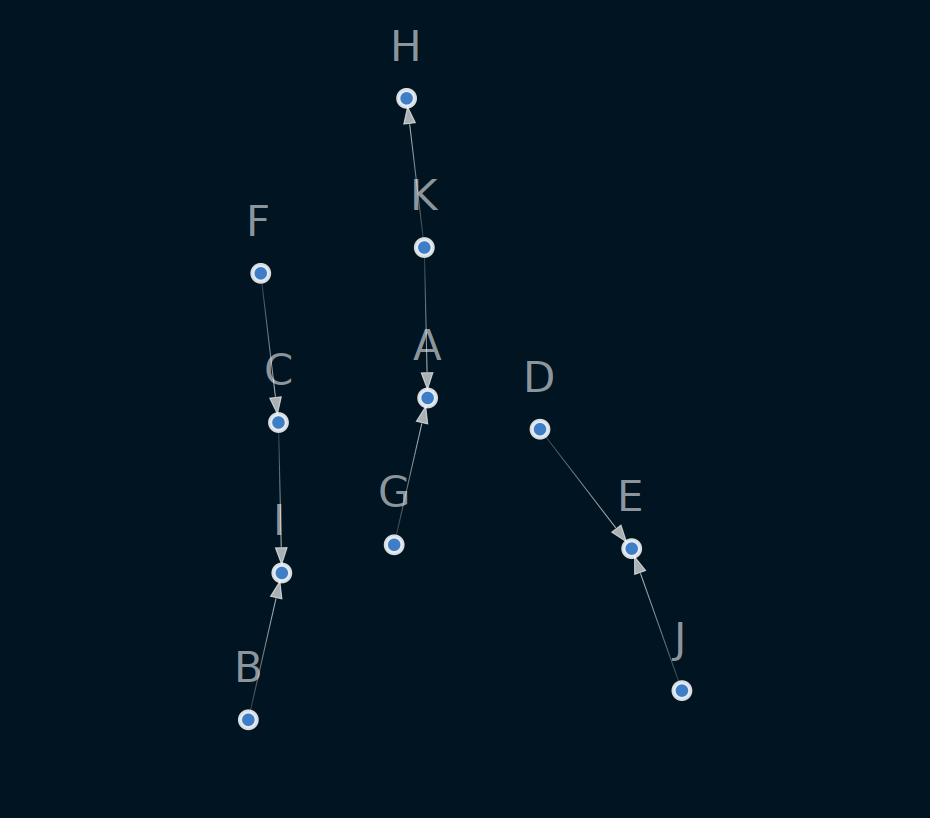

In [4]:
# Approach 1
Result=np.zeros((11,11))
for i in range(len(List_DAG)):
    Result+=List_DAG[i]*List_Weight[i]
SturctualModel=create_graph_from_WeightedArray(Result, threshold=0.8)
viz = plot_structure(
    SturctualModel,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

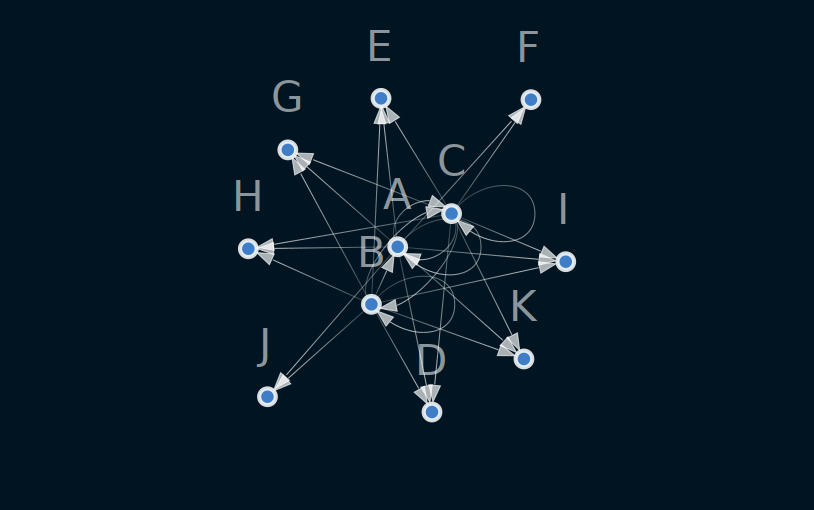

In [5]:
# Approach 2
StructureModel2=create_graph_majorvoting(List_DAG,threshold=0.8)
viz = plot_structure(
    StructureModel2,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

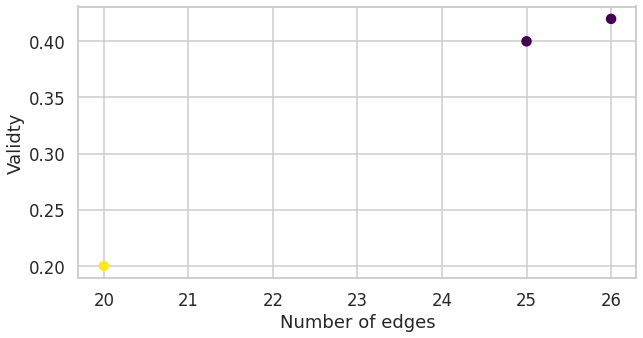

In [6]:
#Approach 3- Clustering based on features
dags, cluster_labels = cluster_dags_based_on_features(List_DAG,List_Weight,threshold=0.8,num_cluster=2)
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(10, 5))
plt.scatter([len(dags.edges) for dags in dags], List_Weight, c=cluster_labels, cmap='viridis')
plt.xlabel('Number of edges')
plt.ylabel('Validty')
plt.show()

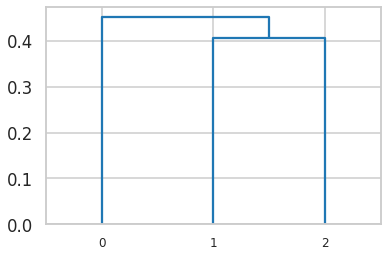

In [7]:
#Approach 4- Hierarchical clustering
linkage_matrix=hierarchical_clustering(List_DAG,threshold=0.8)
dendrogram(linkage_matrix)
plt.show()